# Dados diários de preços e demanda de eletricidade

Recentemente Portugal, Espanha e França tiveram problemas no fornecimento de energia elétrica, então decidir trabalhar em um problema de tal característica.

Não encontrei um dataset a respeito dos três países sobre o respectivo assunto, então escolhi um semelhante, da Austrália.

Esse problema de fornecimento de energia (sendo mais exato, a falta dele) também já aconteceu aqui no Brasil em diferentes datas, sendo o mais recente e significativo, em 2020, no estado do Amapá, que durou 22 dias.

O conjunto de dados abrange 2016 dias, entre 1º de janeiro de 2015 e 6 de outubro de 2020.

Disponível em: https://www.kaggle.com/datasets/aramacus/electricity-demand-in-victoria-australia

## Caracterísitcas do dataset

A seguir, o tipo e a descrição de cada característica do dataset

- **date**: data e hora, a data da gravação

- **demand**: float, uma demanda diária total de eletricidade em MWh (Megawatt por hora)

- **RRP**: float, um preço de varejo recomendado em AUD$ / MWh

- **demand_pos_RRP**: float, uma demanda diária total com RRP positivo em MWh

- **RRP_positive**: float, um RRP positivo médio, ponderado pela demanda intradiária correspondente em AUD$ / MWh

- **demand_neg_RRP**: float, uma demanda diária total com RRP negativo em MWh

- **RRP_negative**: float, um RRP negativo médio, ponderado pela demanda intradiária correspondente em AUD$ / MWh

- **frac_at_neg_RRP**: float, uma fração do dia em que a demanda foi negociada com RRP negativo

- **min_temperature**: float, temperatura mínima durante o dia em Celsius

- **max_temperature**: float, temperatura máxima durante o dia em Celsius

- **solar_exposure**: float, energia solar diária total em MJ/m^2

- **rainfall**: float, precipitação diária em mm

- **school_day**: booleano, se os alunos estavam na escola naquele dia

- **holiday**: booleano, se o dia foi um feriado estadual ou nacional



## Interpretando o dataset

In [102]:
import pandas as pd
dataframe = pd.read_csv("electricity_price_demand.csv")

In [103]:
dataframe.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [104]:
print(dataframe.shape)

(2106, 14)


## Visualizando a série temporal

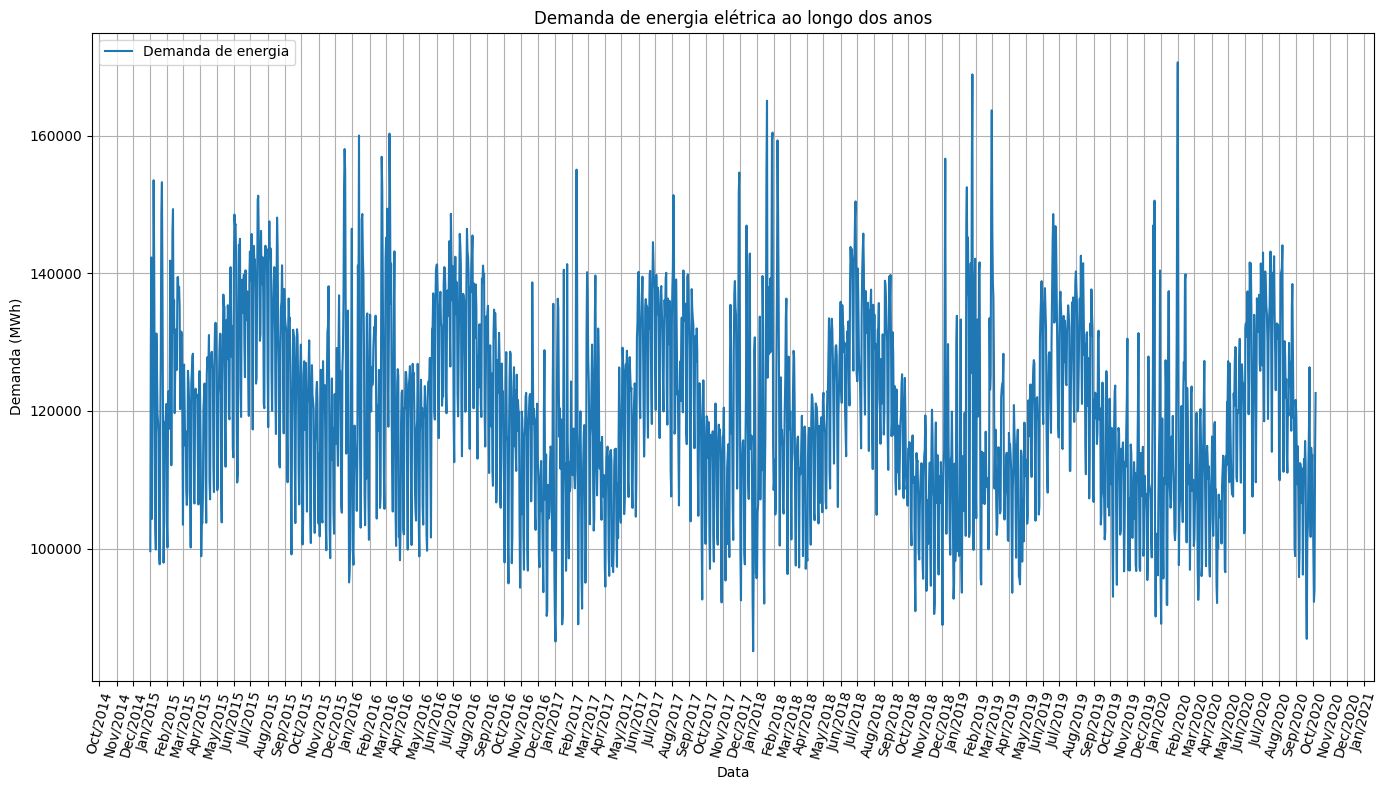

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Conversão e ordenação
dataframe['date_converted'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values('date')

# Plotar
plt.figure(figsize=(14, 8))
plt.plot(dataframe['date_converted'], dataframe['demand'], label='Demanda de energia')

# Mostrar mês/ano no eixo X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))

plt.title('Demanda de energia elétrica ao longo dos anos')
plt.xlabel('Data')
plt.ylabel('Demanda (MWh)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


## Analisando e decompondo a série

Observando o gráfico da série temporal, temos como observar alguns padrões: Como por exemplo o pico de demanda no começo, no meio e no fim do ano. Tendo tendência crescente até o meio do ano e decrescente do meio do ano até o fim (onde ocorre novamente um pico).

Nos dias que ocorrem baixa de demanda, são os dias que não possuem dias escolares ativos. 

Vamos decompor a série para analisar esses comportamentos.

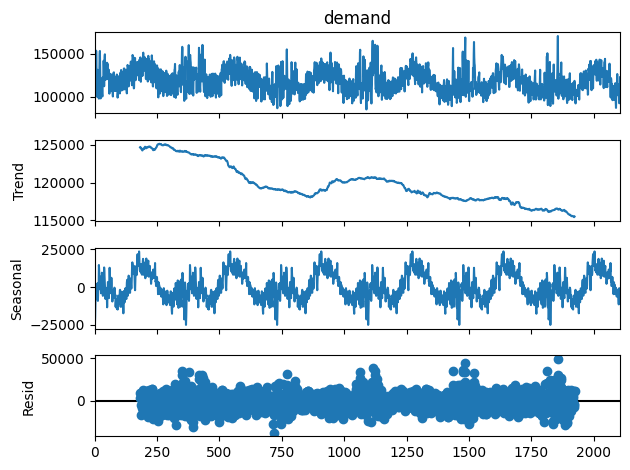

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = dataframe['demand']
result = seasonal_decompose(series, model='additive', period=365)

result.plot()
plt.tight_layout()
plt.show()


Olhando para a decomposição da série, temos uma tendência (trend) de queda na demanda de energia elétrica. Seria por conta de mudanças de consumo? Eficiência energética?

Olhanda para a sazonalidade da mesma, temos ciclos bem definidos na demanda de energia.

A respeito dos ruídos, o modelo parece ter conseguido separar bem. Lembrando que no ano de 2020 aconteceu a pandemia, o que ocasionou nas medidas restritivas, como por exemplo, o fechamento de escolas etc. Isso parece não impactar no gráfico, cujo o mesmo não altera o comportamento como um todo, o que me faz pensar que os dias escolares não é o único motivo para os picos de demanda energética.


## Remoção de tendência e sazonalidade

### Ajustando erro de index ocorido ao ajustar modelo ARIMA.

Como a seguir eu faço a diferenciação das séries (Tendência e Sazonalidade, decidir colocar o ajuste do index anterior à isso).

In [107]:
# Ao ajustar o modelo ARIMA, tive problemas com index, então, tive que setar a coluna date como index do dataframe
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.set_index('date')
dataframe = dataframe.asfreq('D')

### Tendência

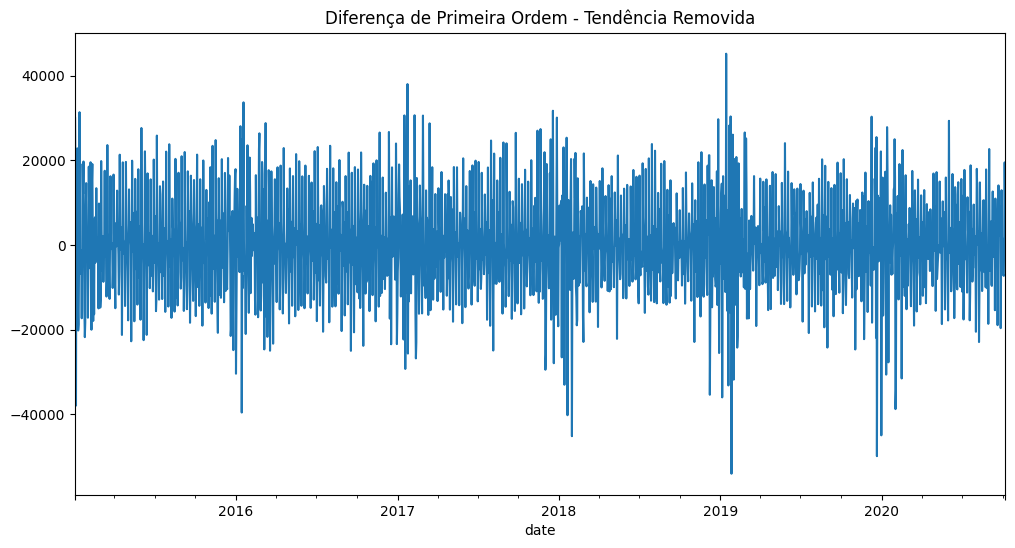

In [108]:
# A série original
# O .diff() faz a subtração entrar o valor atual e o anterior.
# O .dropna() apenas remover a primeira subtracao, dado que é um NaN 
serie_diff1 = dataframe['demand'].diff().dropna()

serie_diff1.plot(figsize=(12, 6), title='Diferença de Primeira Ordem - Tendência Removida')
plt.show()

Observando a série sem tendência, vemos que a mesma varia em torno de 0, com alguns pontos extrapolando mas sem uma tendência de alta ou baixa ao longo do tempo.

### Sazonalidade

De forma analoga ao que fizemos anteriormente, vamos fazer para a sazonalidade.

A diferença é que ao invés de valores diários, vamos calcular anualmente (365 dias).

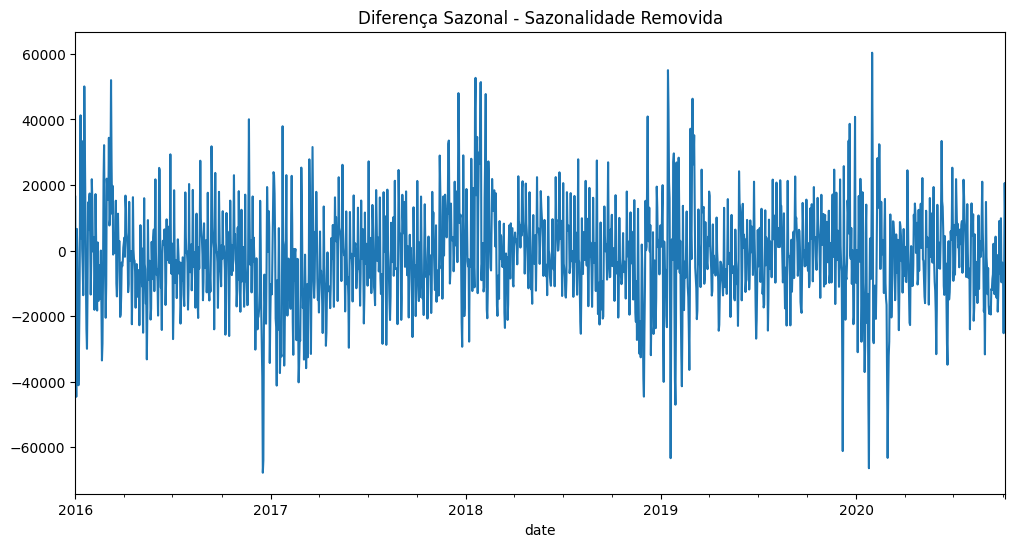

In [109]:
serie_diff_seasonal = dataframe['demand'].diff(365).dropna()

serie_diff_seasonal.plot(figsize=(12, 6), title='Diferença Sazonal - Sazonalidade Removida')
plt.show()

Observando o gráfico de diferença de sazonalidade, temos que os valores giram em torno de 0, porém com alguns picos.

Esses picos podem ser devido a outros fatores como datas comemorativas, estação do ano etc.

Mas o gráfico não mostrar comportamento de alta ou baixa ao longo do tempo.

### Plotando a série sem tendência e sem sazonalidade

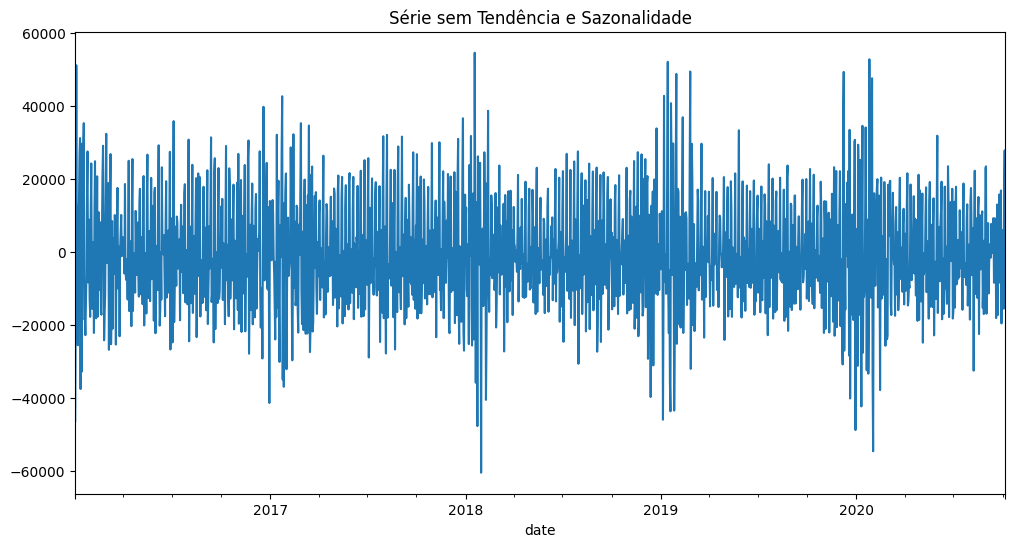

In [110]:
# Combinando os dois códigos anteriores
serie_diff_combined = dataframe['demand'].diff().diff(365).dropna()

serie_diff_combined.plot(figsize=(12, 6), title='Série sem Tendência e Sazonalidade')
plt.show()

Observando a combinação de ambas as remoções, temos que os valores continuam girando em torno de 0, ou seja, temos uma série estacionária!

### Teste de uma série estacionária

Para verificar se de fato temos uma série estacionária, vamos aplicar o teste de Dicker-Fuller aumentado.

(Aqui eu tiver que ler com mais calma para compreender melhor o teste: https://support.minitab.com/pt-br/minitab/help-and-how-to/statistical-modeling/time-series/how-to/augmented-dickey-fuller-test/before-you-start/example/)

In [111]:
from statsmodels.tsa.stattools import adfuller

# série combinada criada anteriormente
result = adfuller(serie_diff_combined)

# Result é uma tupla
print(f'Estatística ADF: {result[0]}')
print(f'Valor-p: {result[1]}')

if result[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série ainda não é estacionária.")


Estatística ADF: -14.279753803850518
Valor-p: 1.330218317827445e-26
A série é estacionária.


Através do teste podemos atestar que a série é estacionária, dado que o resultado do ADF foi menor que 0.05, ou seja, a série é adequada para o modelo que vamos utilizar a seguir: O modelo ARIMA.

## Divisão dos dados e Modelagem

In [112]:
# Dividindo os dados
train_size = int(len(serie_diff_combined) * 0.8)
train = serie_diff_combined[:train_size]
test = serie_diff_combined[train_size:]

Como a série é estacionária, podemos plotar os gráficos ACF e PACF para identificar a influência de cada lag.

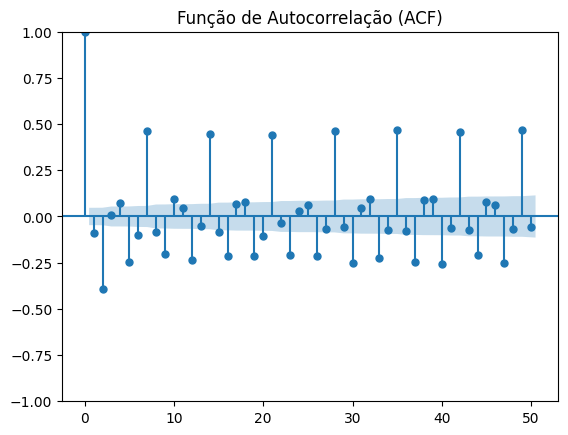

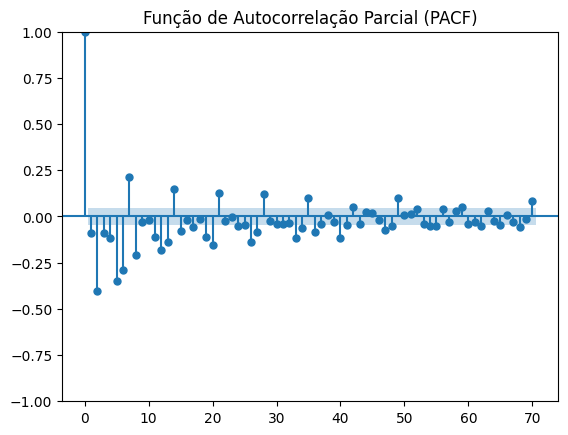

In [113]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plotar o gráfico ACF (Autocorrelation Function)
plot_acf(serie_diff_combined, lags=50)
plt.title('Função de Autocorrelação (ACF)')
plt.show()

# Plotar o gráfico PACF (Partial Autocorrelation Function)
plot_pacf(serie_diff_combined, lags=70)
plt.title('Função de Autocorrelação Parcial (PACF)')
plt.show()


Observando os gráficos ACF e PACF, temos que:

No ACF a autocorrelação começa alta mas imediatamente cai para valores próximos de 0, após isso, ela fica variando para valores abaixo de 0 -> 0 -> Valores acima de 0. Mas sempre de 2 em 2, o que nos sugere um P = 2.

No PACF, o gráfico começa muito alto, depois temos uma tendência abaixo de 0 e após, uma tendência em torno de 0, variando também a cada 2 lags, nos sugerindo um Q=2. No gráfico PACF eu aumentei o lag para 70, apenas para compreender melhor o comportamento.

Vamos utilizar o modelo AR e modelo ARIMA.

### Ajustando o modelo AR

In [125]:
################

### Ajustando o modelo ARIMA
auto-regressivo integrado de médias móveis

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

p = 2 # Gráfico ACF
d = 0 # Já fizemos a diferenciação da série
q = 2 # Gráfico PACF   
                                
model_arima = ARIMA(train, order=(p, d, q))
fit_arima = model_arima.fit()

# Resumo do modelo ajustado
print(fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                 demand   No. Observations:                 1392
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -15065.684
Date:                Mon, 12 May 2025   AIC                          30143.369
Time:                        11:33:35   BIC                          30174.799
Sample:                    01-02-2016   HQIC                         30155.121
                         - 10-24-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -7.1669     12.032     -0.596      0.551     -30.749      16.415
ar.L1          0.1345      0.074      1.826      0.068      -0.010       0.279
ar.L2         -0.0496      0.049     -1.006      0.3

In [124]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

history = list(train)
predictions = []

for i in range(len(test)):
    model = ARIMA(history, order=(p,d,q))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[i])

# Avaliação

#  Erro Quadrático Médio (EQM)
eqm = mean_squared_error(test, predictions)

# Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test, predictions)

# Erro Percentual Absoluto Médio (MAPE)
mape = mean_absolute_percentage_error(test, predictions)

rmse = np.sqrt(eqm)
print(f"🔁 Previsão 1 passo: RMSE = {rmse:.2f}, MAE = {mae:.2f}, MAPE = {mape:.2f}")


🔁 Previsão 1 passo: RMSE = 12947.71, MAE = 9947.13, MAPE = 2.31
